In [513]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [514]:
minim = 1e-8

def uniform(u):
    if abs(u) <= 1:
        return 0.5
    return minim


def triangle(u):
    if abs(u) <= 1:
        return 1 - abs(u)
    return minim


def epanechnikov(u):
    if abs(u) <= 1:
        return 3 / 4 * (1 - u ** 2)
    return minim


def quartic(u):
    if abs(u) <= 1:
        return 15 / 16 * (1 - u ** 2) ** 2
    return minim


def triweight(u):
    if abs(u) <= 1:
        return 35 / 32 * (1 - u ** 2) ** 3
    return minim


def tricube(u):
    if abs(u) <= 1:
        return 70 / 81 * (1 - abs(u) ** 3) ** 3
    return minim


def cosine(u):
    if abs(u) <= 1:
        return np.pi / 4 * np.cos(np.pi * u / 2)
    return minim


def gaussian(u):
    return 1 / ((2 * np.pi) ** 0.5) * np.exp(-u ** 2 / 2)


def logistic(u):
    return 1 / (np.exp(u) + 2 + np.exp(-u))


def sigmoid(u):
    return 2 / (np.pi * (np.exp(u) + np.exp(-u)))


def silverman(u):
    return 1 / 2 * np.exp(-abs(u) / (2 ** 0.5)) * np.sin(abs(u) / (2 ** 0.5) + np.pi / 4)


def cosine_dist(a, b):
    return spatial.distance.cosine(a, b)


def minkowski_dist(a, b, p):
    return spatial.distance.minkowski(a, b, p)

In [515]:
kernels = {
    'uniform': uniform,
    'logistic': logistic,
    'triangle': triangle,
    'epanechnikov': epanechnikov,
    'quartic': quartic,
    'triweight': triweight,
    'tricube': tricube,
    'cosine': cosine,
    'gaussian': gaussian,
    'sigmoid': sigmoid,
    'silverman': silverman
}

dists = {
    'cosine': cosine_dist,
    'minkowski': minkowski_dist
}


In [516]:

def calc(dist, kernel, x_train, y_train, point, h=None, k=None, p=None, weights=None):
    K = kernels[kernel]
    d = dists[dist]
    max_sum = -1000
    result1 = None
    b = h is None
    for y in range(4, 8):
        nearest = NearestNeighbors(
            n_neighbors=5 if k is None else k + 1,
            radius=1000000 if h is None else h,
            metric=dist
        )
        nearest.fit(x_train, y_train)
        neighs = nearest.kneighbors(X=point.reshape(1, -1), n_neighbors=50 if k is None else k + 1)
        cur_sum = 0
        if b:
            if dist == 'minkowski':
                h = max(d(x_train[i], point, p) for i in neighs[1][0])
            else:
                h = max(d(x_train[i], point) for i in neighs[1][0])
            if h == 0:
                h = 0.00000000000001
        for i1 in neighs[1][0]:
            if dist == 'minkowski':
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point, p) / h) * (1 if weights is None else weights[i1])
            else:
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point) / h) * (1 if weights is None else weights[i1])
        if cur_sum > max_sum:
            max_sum = cur_sum
            result1 = y
    return result1

In [517]:

def calcWeight(dist, kernel, x_train, y_train, point, h=None, k=None, p=None, weights=None):
    K = kernels[kernel]
    d = dists[dist]
    max_sum = -1000
    result1 = None
    b = h is None
    for y in range(4, 8):
        nearest = NearestNeighbors(
            n_neighbors=5 if k is None else k + 1,
            radius=1000000 if h is None else h,
            metric=dist
        )
        nearest.fit(x_train, y_train)
        neighs = nearest.kneighbors(X=point.reshape(1, -1), n_neighbors=50 if k is None else k + 1)
        cur_sum = 0
        if b:
            if dist == 'minkowski':
                h = max(d(x_train[i], point, p) for i in neighs[1][0])
            else:
                h = max(d(x_train[i], point) for i in neighs[1][0])
            if h == 0:
                h = 0.00000000000001
        for i1 in neighs[1][0]:
            if dist == 'minkowski':
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point, p) / h) * (1 if weights is None else weights[i1])
            else:
                cur_sum += int(y == y_train[i1]) * K(d(x_train[i1], point) / h) * (1 if weights is None else weights[i1])
        if cur_sum > max_sum:
            max_sum = cur_sum
            result1 = y
    return max_sum

In [518]:
def custom_weights(kernel, weights):
    return np.array([kernels[kernel](w) for w in weights[0]]).reshape(1, -1)

def libCalc(dist, kernel, x_train, y_train, point, h=None, k=None, p=None, weights=None):
    knn = KNeighborsClassifier(weights=lambda weights: custom_weights(kernel, weights), n_neighbors=5 if k is None else k + 1, metric=dist)
    knn.fit(x_train, y_train)
    prediction = knn.predict(point.reshape(1, -1))

    return prediction[0]

In [519]:
def calcAll(func, dist, kernel, x_train, y_train, points, h=None, k=None, p=None, weights=None):
    res = []
    for point in points:
        res.append(func(dist, kernel, x_train, y_train, point, h=h, k=k, p=p, weights=weights))
    return res

In [520]:
data = pd.read_csv('winequality-white.csv')
data = data[(data['quality'] != 3) & (data['quality'] != 9)]
x_data = data.drop('quality', axis=1)
y_data = data['quality']
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [521]:
def calcTemplate(trial, func, weights1=None):
    sampled = []
    if(func == libCalc and weights1 is not None):
        for i in range(len(x_train)):
            sampled.append(x_train[i] * weights1[i])
    dist = trial.suggest_categorical('dist', ['cosine', 'minkowski'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'logistic', 'triangle', 'epanechnikov', 'quartic'
                                                  , 'triweight', 'tricube', 'cosine', 'gaussian', 'sigmoid', 'silverman'])
    h = trial.suggest_int('h', 1, 100)
    k = trial.suggest_int('k', 1, 20) if dist != 'minkowski' else None
    p = trial.suggest_int('p', 1, 10) if dist == 'minkowski' else None
    
    res = calcAll(func=func, dist=dist, kernel=kernel, x_train=x_train, y_train=y_train.to_numpy(),
                   points=x_test, h=h, k=k, p=p, weights=weights1)
    
    return mean_squared_error(y_test, res)

In [522]:
def objectiveMy(trial):
    return calcTemplate(trial, calc)

def objectiveLib(trial):
    return calcTemplate(trial, libCalc)

studyLib = optuna.create_study(direction='minimize')
studyLib.optimize(objectiveLib, n_trials=200)

best_params = studyLib.best_params
print("Best parameters for lib version:", best_params)

studyMy = optuna.create_study(direction='minimize')
studyMy.optimize(objectiveMy, n_trials=200)

best_params = studyMy.best_params
print("Best parameters for my version:", best_params)

[I 2024-05-28 10:35:02,772] A new study created in memory with name: no-name-09773ae8-31ce-4790-ab7c-f81a86a5f3b2
[W 2024-05-28 10:35:02,777] Trial 0 failed with parameters: {'dist': 'minkowski', 'kernel': 'triangle', 'h': 49, 'p': 8} because of the following error: ValueError("All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.").
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_88697/2712954165.py", line 5, in objectiveLib
    return calcTemplate(trial, libCalc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_88697/1092373316.py", line 13, in calcTemplate
    res = calcAll(func=func, dist=dist, kernel=kernel, x_train=x_train, y_train=y_train.to_numpy(),
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: All neighbors of some sample is getting zero weights. Please modify 'weights' to avoid this case if you are using a user-defined function.

In [ ]:
def compare_accuracy(error_func, x_train, y_train, x_test, y_test, k_values, weights = None):
    calc_accuracy_k = []
    lib_calc_accuracy_k = []

    for k in k_values:
        print(k)
        calc_predictions_k = [calc('cosine', 'silverman', x_train, y_train, point, k=k, weights=weights) for point in x_test]
        lib_calc_predictions_k = [libCalc('cosine', 'silverman', x_train, y_train, point, k=k) for point in x_test]
        calc_accuracy_k.append(error_func(y_test, calc_predictions_k))
        lib_calc_accuracy_k.append(error_func(y_test, lib_calc_predictions_k))

    results_k = pd.DataFrame({
        'k': k_values,
        'calc_accuracy': calc_accuracy_k,
        'lib_calc_accuracy': lib_calc_accuracy_k
    })

    plt.figure()
    plt.plot(k_values, calc_accuracy_k, label='calc')
    plt.plot(k_values, lib_calc_accuracy_k, label='libCalc')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy vs. k ')
    plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


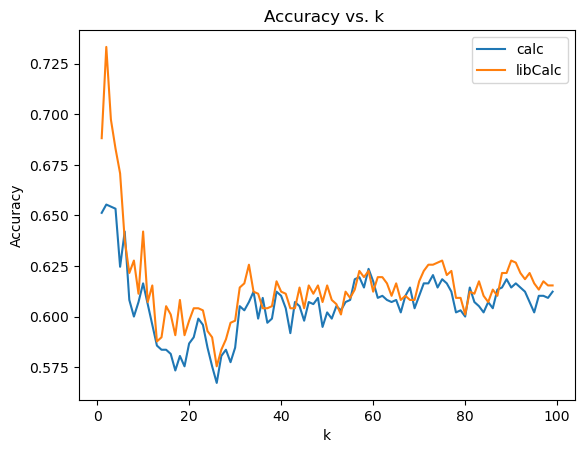

In [ ]:
compare_accuracy(
    error_func=mean_squared_error,
    x_train=x_train,
    y_train=y_train.to_numpy(),
    x_test=x_test,
    y_test=y_test.to_numpy(),
    k_values=np.arange(1, 100),
)

In [ ]:
def lowess(x_train, y_train, func):
    weights = []
    for i in range(len(x_train)):
        if i < len(x_train):
            d_X = np.delete(x_train, i, axis=0)
            d_y = np.delete(y_train, i, axis=0)
            weight = func('cosine', 'silverman', d_X, d_y, x_train[i], h=None, k=25, p=None)
            weights.append(weight)
    return weights

In [ ]:
weights = lowess(x_train, y_train.to_numpy(), calcWeight)
def objectiveMyWeights(trial):
    return calcTemplate(trial, calc, weights)

def objectiveLibWeights(trial):
    return calcTemplate(trial, libCalc, weights)

studyLib = optuna.create_study(direction='minimize')
studyLib.optimize(objectiveLibWeights, n_trials=200)

best_params = studyLib.best_params
print("Best parameters for lib version:", best_params)

studyMy = optuna.create_study(direction='minimize')
studyMy.optimize(objectiveMyWeights, n_trials=200)

best_params = studyMy.best_params
print("Best parameters for my version:", best_params)

[I 2024-05-28 10:21:39,551] A new study created in memory with name: no-name-77959607-90a0-4a6d-b042-2b4ad14a4f40
[W 2024-05-28 10:21:39,563] Trial 0 failed with parameters: {'dist': 'minkowski', 'kernel': 'cosine', 'h': 85, 'p': 5} because of the following error: ValueError('The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()').
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_88697/1534446892.py", line 6, in objectiveLibWeights
    return calcTemplate(trial, libCalc, weights)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_88697/1092373316.py", line 13, in calcTemplate
    res = calcAll(func=func, dist=dist, kernel=kernel, x_train=x_train, y_train=y_train.to_numpy(),
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
compare_accuracy(
    error_func=mean_squared_error,
    x_train=x_train,
    y_train=y_train.to_numpy(),
    x_test=x_test,
    y_test=y_test.to_numpy(),
    k_values=np.arange(1, 100),
    weights=weights
)